In [1]:
audio_path = "audio-data/drumloop2.mp3"
name = "drumloop2"

# segmentation
block_length = 1 # number of frames in a stream block
frame_beats = 1 / 2 # frame size in beats
hop_beats = 1 / 2 # hop length in beats
detect_BPM = False
BPM = 120
## alternatively, you can specify frame length and hop length in seconds
# frame_length_s = 0.1
# hop_length_s = 0.02
## or in samples
# frame_length = 4096
# hop_length = 1024

# feature extraction
extract_mfccs = True

# clustering
n_classes = 3
maxlen = 16

# model architecture and training
step = 2 # step size for sliding window
hidden_units = 24 # number of hidden units in GRU layer
epochs = 10
batch_size = 32
validation_split = 0.2
early_stopping = False
checkpoint = True
patience = 5 # number of epochs to wait before early stopping

# utility
verbose = 1 # print additional information
directory = "."

In [2]:
def beats_to_samples(beats, bpm, sr):
    beats_per_second = bpm / 60.0
    samples_per_beat = sr / beats_per_second
    total_samples = int(samples_per_beat * beats)
    return total_samples

In [3]:
beats_to_samples(1, 120, 44100)

22050

In [4]:
60 * 1 * 22050 / 120

11025.0

In [5]:
import math
math.floor(240 * 1 * 22050 / 120)

44100

In [6]:
# import dependencies
import argparse
from pathlib import Path
import math
import numpy as np, matplotlib.pyplot as plt, librosa
import matplotlib.ticker as mticker
import librosa.display
from IPython.display import Audio, display
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import json
from numpyencoder import NumpyEncoder
from sklearn import preprocessing, cluster
from streamer import Streamer
import scipy
from keras.utils import to_categorical
from keras import Sequential
import pickle

sr = librosa.get_samplerate(audio_path)
if BPM is not None and frame_beats is not None:
    frame_length = beats_to_samples(frame_beats, BPM, sr)
    frame_length_s = frame_length / sr
if BPM is not None and hop_beats is not None:
    hop_length = beats_to_samples(hop_beats, BPM, sr)
    hop_length_s = hop_length / sr
stream = Streamer(audio_path, block_length, frame_length, hop_length)
path = Path(directory + "/models/" + name)
path.mkdir(exist_ok=True, parents=True)

In [7]:
# helper function to extract features from audio block
def extract_features(y, sr, extract_mfccs=False):
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=hop_length, hop_length=hop_length)
    spectral_bandwith = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=hop_length, hop_length=hop_length)
    spectral_flatness = librosa.feature.spectral_flatness(y=y, n_fft=hop_length, hop_length=hop_length)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=hop_length, hop_length=hop_length)
    m_centroid = np.median(spectral_centroid, axis=1)
    m_bandwith = np.median(spectral_bandwith, axis=1)
    m_flatness = np.median(spectral_flatness, axis=1)
    m_rolloff = np.median(spectral_rolloff, axis=1)
    if extract_mfccs:        
        if y.size >= 2048:  
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, center=False, n_fft=hop_length, hop_length=hop_length) # mfccs
        else:
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=len(y), hop_length=len(y), center=False)
        m_mfccs = np.median(mfccs[:], axis=1)
    features = np.array([])
    features = np.concatenate((
        features,
        m_centroid,
        m_bandwith,
        m_flatness,
        m_rolloff
    ))
    if extract_mfccs:
        features = np.concatenate((
            features,
            m_mfccs
        ))
    if len(features) == 0:
        return None
    return features

Audio length: 192.0s, 9216000 samples
Sample rate: 48000 Hz
Frame length: 0.25s,  12000 samples
Hop length: 0.25s, 12000 samples
Block length: 1 frame(s)
Number of blocks: 768
(768, 17)
(768, 17)
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.99749423 -0.99265103 -0.99993997 -0.99531506 -0.99720893  0.99801783
  0.99755365  0.59262146  0.99894882 -0.51168478  0.99309176  0.87493413
  0.99134794  0.37794501  0.99310999 -0.98271119  0.99318039]


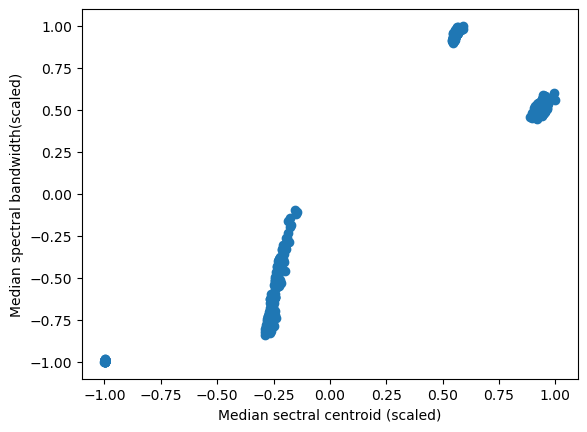

In [8]:
print(f"Audio length: {stream.length}s, {stream.n_samples} samples")
print(f"Sample rate: {sr} Hz")
print(f"Frame length: {frame_length_s}s,  {frame_length} samples")
print(f"Hop length: {hop_length_s}s, {hop_length} samples")
print(f"Block length: {block_length} frame(s)")
print(f"Number of blocks: {len(stream)}")

# extract features from each block in audio stream
features = np.array([extract_features(block, sr, extract_mfccs=extract_mfccs) for block in stream.new()])
# features_scaled = features
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(features)
# features_scaled = preprocessing.scale(features, axis=0) # should it be axis 0 then not 1??
if verbose:
    # print(features[0])
    print(features.shape)
    print(features_scaled.shape)
    print(features_scaled.min(axis=0))
    print(features_scaled.max(axis=0))
    print(features_scaled[0]) # type: ignore
if verbose:
    plt.scatter(features_scaled[:,0], features_scaled[:,1], ) # type: ignore
    plt.xlabel('Median sectral centroid (scaled)')
    plt.ylabel('Median spectral bandwidth(scaled)')
    plt.show()
    # plt.scatter(features_scaled[:,0], features_scaled[:,1], ) # type: ignore
    # plt.show()

In [9]:
# cluster features
c_model = cluster.KMeans(n_clusters=n_classes, n_init='auto')
labels = c_model.fit_predict(features_scaled)
labels[:4]

array([0, 1, 2, 1], dtype=int32)

/var/folders/kt/3yzrdbd548lfc1w4yd4phlwm0000gn/T/ipykernel_85952/1695150304.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n_classes)


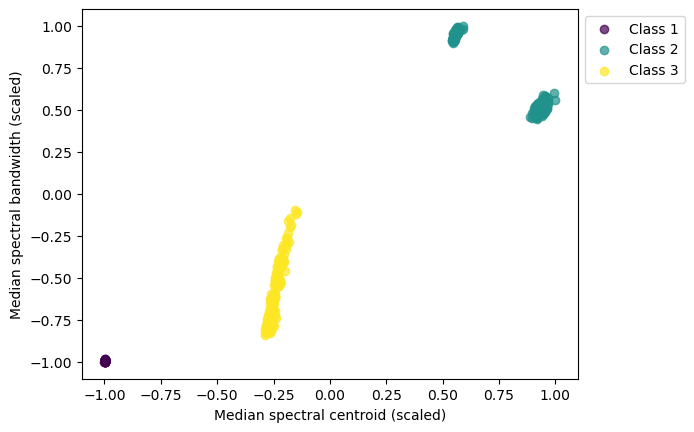

In [10]:
# Define a color map for the clusters
cmap = plt.cm.get_cmap('viridis', n_classes)

# Plot the data points with colors corresponding to their labels and add labels to legend
for i in range(n_classes):
    plt.scatter(features_scaled[labels==i, 0], features_scaled[labels==i, 1], color=cmap(i), alpha=0.7, label='Class {}'.format(i+1))
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Median spectral centroid (scaled)')
plt.ylabel('Median spectral bandwidth (scaled)')
plt.savefig(path / (name + "_clusters.png"), bbox_inches='tight')
plt.show()

In [11]:
n_labels = len(np.unique(labels))
labels = labels.tolist()
# save labelled sequence of frames
labels_path = path / (name + "_labels.csv")
np.savetxt(labels_path, (labels), fmt='%s,')
if verbose:
    print(f"Total labelled frames: {len(labels)}")
    print(f"n_labels: {n_labels} (sanity check)")
    print("Labelled frame sequence saved to: " + str(labels_path))

Total labelled frames: 768
n_labels: 3 (sanity check)
Labelled frame sequence saved to: models/drumloop2/drumloop2_labels.csv


In [12]:

frames = []
for i, block in enumerate(stream.new()):
    frames.append([i * hop_length, i * hop_length + frame_length])
# frames # sanity check

# each dict value has to be a 1D interlaved array, as Max dict object has trouble reading 2D arrays
# start sample is always stored at an even index and is followed by end sample
labelled_frames = dict()
for label, frame in zip(labels, frames):
    if label not in labelled_frames:
        labelled_frames[label] = []
    labelled_frames[label].extend(frame) # use extend instead of append
if verbose:    
    print(len(labelled_frames[0])) # sanity check
    print(labelled_frames[0][0], labelled_frames[0][1]) # sanity check

# build a subsequence for every <step> frames
# and a corresponding label that follows it
x = [] # these will be features
y = [] # these will be targets
for i in range(0, len(labels) - maxlen, step):
    x.append(labels[i: i + maxlen])
    y.append(labels[i + maxlen])
# x_ = np.array(features)
# y_ = np.array(targets)
# one-hot encode features and targets
x_ = to_categorical(x, dtype ="bool")
y_ = to_categorical(y, dtype ="bool")
# sanity check
if verbose:
    print(x_.shape)
    print(y_.shape)

384
0 12000
(376, 16, 3)
(376, 3)


In [13]:
# adapted from code by Lukas Biewald
# https://github.com/lukas/ml-class/blob/master/projects/7-text-generation/char-gen.py
model_path = path / (name + ".keras")
inputs = Input(shape=(maxlen, n_labels), name='input_layer')
x = GRU(hidden_units, name='gru_layer')(inputs)
outputs = Dense(n_labels, activation='softmax', name='output_layer')(x)
model = Model(inputs=inputs, outputs=outputs)
model._name = name
callbacks = []
if early_stopping:
    callbacks.append(EarlyStopping(
        monitor='val_loss',
        patience=patience
    ))
if checkpoint:
    callbacks.append(ModelCheckpoint(
        filepath=model_path,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
    ))
model.compile(
    loss='categorical_crossentropy', # since we are using one-hot encoded labels
    optimizer="adam",
    metrics=['accuracy']
    )
model.summary()


history = model.fit(
    x_,
    y_,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=0.2,
    callbacks=callbacks
)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "drumloop2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 16, 3)]           0         
                                                                 
 gru_layer (GRU)             (None, 24)                2088      
                                                                 
 output_layer (Dense)        (None, 3)                 75        
                                                                 
Total params: 2,163
Trainable params: 2,163
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2023-05-30 04:31:00.910375: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 3s 151ms/step - loss: 1.0895 - accuracy: 0.0800 - val_loss: 1.0528 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 0s 25ms/step - loss: 1.0294 - accuracy: 0.5000 - val_loss: 0.9976 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 0s 25ms/step - loss: 0.9770 - accuracy: 0.5000 - val_loss: 0.9494 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 0s 25ms/step - loss: 0.9314 - accuracy: 0.5000 - val_loss: 0.9076 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 0s 25ms/step - loss: 0.8920 - accuracy: 0.5000 - val_loss: 0.8712 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 0s 24ms/step - loss: 0.8579 - accuracy: 0.5000 - val_loss: 0.8404 - val_accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 0s 24ms/step - loss: 0.8292 - accuracy: 0.5000 - val_loss: 0.8141 - val_accuracy: 0.5000
Epoch 8/10
10/10 [=====

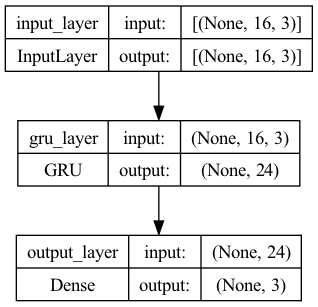

In [14]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [15]:
print(f"Saved model to: {path}")
d_path = path / (name + "_frames.json")
d_path.write_text(json.dumps(labelled_frames, cls=NumpyEncoder))
config = dict()
config["filename"] = audio_path.split('/')[-1]
config["sr"] = sr
config["BPM"] = BPM
config["frame_beats"] = frame_beats
config["hop_beats"] = hop_beats
config["n_classes"] = int(n_classes)
config["maxlen"] = int(maxlen)
config["onset_detection"] = False
config["hop_length"] = hop_length
config["frame_length"] = frame_length
config["block_length"] = block_length
c_path = path / (name + "_config.json")    
c_path.write_text(json.dumps(config))
if verbose:
    print(f"Saved model to: {model_path}")
    print(f"Saved frames to: {d_path}")
    print(f"Saved config to: {c_path}")

Saved model to: models/drumloop2
Saved model to: models/drumloop2/drumloop2.keras
Saved frames to: models/drumloop2/drumloop2_frames.json
Saved config to: models/drumloop2/drumloop2_config.json


In [16]:
history = history.history
h_path = path / (name + "_history")
with open(h_path, 'wb') as file_pi:
    pickle.dump(history, file_pi)
if verbose:
    print(f"Saved history to: {h_path}")

Saved history to: models/drumloop2/drumloop2_history


In [17]:
with open(h_path, "rb") as file_pi:
    history = pickle.load(file_pi)

In [18]:
print(f"Total epochs : {len(history['loss'])}")
print("Minimum validation loss: ", min(history['val_loss']), "\nEpoch: ", np.argmin(history['val_loss']))
print("Maximum validation accuracy: ", max(history['val_accuracy']), "\nEpoch: ", np.argmax(history['val_accuracy']))

Total epochs : 10
Minimum validation loss:  0.75580233335495 
Epoch:  9
Maximum validation accuracy:  0.5 
Epoch:  0


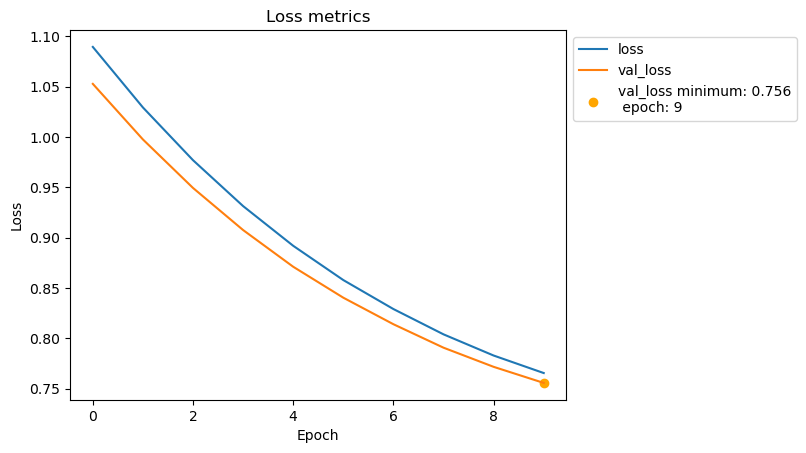

In [19]:
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
vl_min = min(history['val_loss'])
vl_min_epoch = np.argmin(history['val_loss'])
plt.scatter(vl_min_epoch, vl_min,c='orange', label=f'val_loss minimum: {vl_min:.3f}\n epoch: {vl_min_epoch}')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("Loss metrics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.tight_layout()
plt.savefig(path / (name + "_loss.png"), bbox_inches='tight')
plt.show()

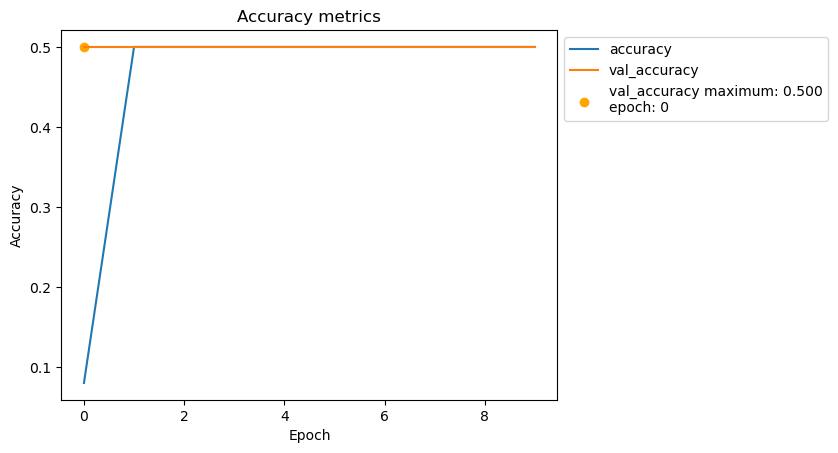

In [20]:
plt.plot(history["accuracy"], label="accuracy")
plt.plot(history["val_accuracy"], label="val_accuracy")
va_max = max(history['val_accuracy'])
va_max_epoch = np.argmax(history['val_accuracy'])
plt.scatter(va_max_epoch, va_max,c='orange', label=f'val_accuracy maximum: {va_max:.3f}\nepoch: {va_max_epoch}')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("Accuracy metrics")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(path / (name + "_accuracy.png"), bbox_inches='tight')
plt.show()

In [21]:
seq = labels[:16]
print("Sequence do detokenise:\n", seq)
out = []
for label in seq:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Sequence do detokenise:
 [0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1]


In [22]:
y, sr = librosa.load(audio_path, sr=sr)

In [25]:
out

array([ 0.        ,  0.        ,  0.        , ..., -0.00083686,
       -0.0008249 , -0.00081972])

In [26]:
cd samps

/Users/wwerkowicz/GS/MC/MC-FP/MC-FP-debug/samps


In [27]:
import soundfile as sf
c = 2
# out = np.array([])
for i, ind in enumerate(labelled_frames[c]):
    if i % 2:
        start = labelled_frames[c][i-1]
        end = labelled_frames[c][i]
        # print(start,end)
        frame = np.array(y[start:end])
        # print(frame)
        # out = np.concatenate((out, frame))
        # print(out)
        # display(Audio(frame, rate=sr))
        ind = int(i / 2)
        sampname = f"class_{c}_{ind}.wav" 
        sf.write(sampname, frame, sr)

In [28]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = preds[0]
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    # print(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [29]:
def generate(prompt=[], length=4, temperature=-1, include_prompt=False, verbose=0):
    # print("Read prompt: ", prompt)
    # generate a sequence of given length       
    if len(prompt) == 0:
        # if it's there's no prompt, use an array of zeroes
        prompt = np.zeros((maxlen), dtype="uint8")
        print(f"No prompt provided, using {maxlen} zeroes instead.")
    elif len(prompt) < maxlen:
        # if prompt is too short, pad it with zeroes from the left to match correct input shape
        prompt = np.pad(prompt, (maxlen - len(prompt), 0), 'constant', constant_values=(0, 0))
        print("Prompt too short, padded to length: ", maxlen)
    elif len(prompt) > maxlen:
        # if it's too long, then trim it
        prompt = prompt[-maxlen:]
        print(f"Prompt too long, using {maxlen} last elements: ")
    prompt_ = to_categorical(prompt, num_classes=n_classes)
    prompt_ = np.array([prompt_])
    
    seq = []
    for i in range(length):
        # make prediction based on prompt
        ps = model.predict(prompt_, verbose=verbose)
        # sample from predictions
        if temperature > 0.01:
            p_label = np.argmax(ps)
        else:
            p_label = sample(ps, temperature)
        # add sampled label to sequence
        seq.extend([int(p_label)])
        # one-hot encode sampled label
        p_label_ = to_categorical(p_label, num_classes=n_classes)
        p_label_ = np.array([[p_label_]])
        # append encoded label to the prompt for next prediction
        prompt_ = np.append(prompt_, p_label_, axis=1)
    if include_prompt:
        prompt = np.append(prompt, seq)
        return prompt
    else:
        return seq

In [30]:
seq_ = generate(seq, length=16, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Generated sequence:
 [2, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 2, 0, 0, 1]


LibsndfileError: Error opening 'audio-data/drumloop2.mp3': System error.

In [ ]:
seq_ = generate(seq, length=16, temperature=1.0, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

In [ ]:
seq_ = generate(seq, length=16, temperature=2.0, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

In [ ]:
seq_ = generate(seq, length=16, temperature=3.0, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

In [ ]:
seq_ = generate(seq, length=16, temperature=5.0, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

In [ ]:
def plot_audio_with_color_overlay(sequence, labelled_frames, stream, sr):
    seq_ = generate(sequence, length=16, include_prompt=False)
    print("Generated sequence:\n", seq_)
    out = []
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
              'tab:olive', 'tab:cyan']  # Add more colors if needed
    fig, ax = plt.subplots()
    for i, label in enumerate(seq_):
        frame = stream.get_frame(labelled_frames, label, index=0)
        out = np.concatenate((out, frame))
        ax.plot(np.linspace(i, i + 1, len(frame)), frame, color=colors[label % len(colors)])
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title('Audio with Color-Coded Label Overlay')
    plt.show()
    display(Audio(out, rate=sr))
